# Imports


In [137]:
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autogluon.tabular import TabularPredictor
from scipy.interpolate import interp1d

# Load Synthetic Data

The data below was generated with the "Mostly.ai" synthetic data generator using the adult training dataset.


In [18]:
df = pd.read_csv("../Datasets/Adult-UCI/synthetic-mostly-ai.csv")
df

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,51,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
1,38,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,<=50K
2,43,Private,Bachelors,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,98,South,<=50K
3,47,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,45,Mexico,<=50K
4,41,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39069,46,Federal-gov,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
39070,30,?,Some-college,Never-married,?,Own-child,Black,Male,0,0,50,United-States,<=50K
39071,27,Private,HS-grad,Never-married,Machine-op-inspct,Other-relative,White,Male,0,0,40,United-States,<=50K
39072,56,Federal-gov,Prof-school,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [68]:
print(
    "How many previledged entries are in each group and what's the percentaged of it?"
)
print(
    r"As a reminder, our non-synthetic data has ~30% of positive entries in the previldged group and ~11% in the unpreviledged group",
    "\n",
)

mask_previledged = df["income"] == ">50K"
mask_male = df["sex"] == "Male"
mask_female = df["sex"] == "Female"

num_previleged_males = sum(mask_previledged & mask_male)
num_previleged_females = sum(mask_previledged & mask_female)

print(
    f"{'Males with >50K income: ':<35}",
    num_previleged_males,
    "-",
    f"{num_previleged_males / sum(mask_male):.1%} of all males",
)

print(
    f"{'Females with >50K income: ':<35}",
    num_previleged_females,
    "-",
    f"{num_previleged_females / sum(mask_female):.1%} of all females",
)

print(
    f"{'Ratio of prev. females to males: ':<35}",
    f"{num_previleged_females / num_previleged_males:.1%}",
)

How many previledged entries are in each group and what's the percentaged of it?
As a reminder our non-synthetic data has ~30% of previledged entries in the previldged group and ~11% in the unpreviledged group 

Males with >50K income:             8047 - 30.7% of all males
Females with >50K income:           1459 - 11.3% of all females
Ratio of prev. females to males:    18.1%


# Train the post processing classifier Model

The objective of this model is to give a soft prediction (probability) for the target variable.


In [65]:
there_is_a_trained_model = len(os.listdir("ag_models_probability_synthetic_data")) > 0

if there_is_a_trained_model:
    pp_clf = TabularPredictor.load(
        "ag_models_probability_synthetic_data/"
        + sorted(os.listdir("AutogluonModels"))[-1],
        verbosity=0,
    )
else:
    pp_clf = TabularPredictor(
        label="income", path="ag_models_probability_synthetic_data"
    ).fit(
        train_data=df,
        presets="best_quality",
        verbosity=1,
    )

In [184]:
# Percentage of positive entries in each group for each model

percentages_models = []

for model in pp_clf.get_model_names():
    start_time = time()
    probabilities = pp_clf.predict(df, model=model)
    mask_previledged = probabilities == ">50K"
    num_previleged_males = sum(mask_previledged & mask_male)
    num_previleged_females = sum(mask_previledged & mask_female)
    percentages_models.append(
        [
            model,
            num_previleged_males / sum(mask_male),
            num_previleged_females / sum(mask_female),
            num_previleged_females / num_previleged_males,
            time() - start_time,
        ]
    )

# Dataframe formating

format_mapping = {
    "model": str,
    "male": "{:.1%}",
    "female": "{:.1%}",
    "ratio f to m": "{:.1%}",
    "time to predict": "{:.1f} s",
}

# Built dataframe only for display

(
    pd.DataFrame(
        percentages_models,
        columns=["model", "male", "female", "ratio f to m", "time to predict"],
    )
    .set_index("model")
    .sort_values("female", ascending=False)
    .style.format(format_mapping)
    .set_caption("Percentage of individuals with >50K income in each model")
)

,male,female,ratio f to m,time to predict
model,,,,
ExtraTreesGini_BAG_L1,29.8%,11.1%,18.3%,1.1 s
RandomForestGini_BAG_L1,29.8%,11.1%,18.3%,1.0 s
ExtraTreesEntr_BAG_L1,29.8%,11.1%,18.3%,1.0 s
RandomForestEntr_BAG_L1,29.9%,11.1%,18.2%,0.9 s
KNeighborsUnif_BAG_L1,18.2%,9.0%,24.3%,1.0 s
KNeighborsDist_BAG_L1,18.2%,8.9%,24.2%,1.1 s
LightGBMXT_BAG_L1,25.2%,7.9%,15.4%,1.4 s
NeuralNetFastAI_BAG_L1,25.1%,7.8%,15.4%,5.1 s
NeuralNetTorch_BAG_L1,24.6%,7.8%,15.7%,1.6 s


## Model selection

Here the top 4 models all had a very close relation to our original data, as such I'll pick `RandomForestEntr_BAG_L1` as it had the fastest prediction time from all of them.


In [73]:
df_proba = df.copy()
df_proba["income_synthetic"] = [1 if x == ">50K" else 0 for x in df_proba["income"]]
df_proba["income_model_probability"] = pp_clf.predict_proba(
    df, model="RandomForestEntr_BAG_L1"
)[">50K"]
df_proba = df_proba.drop("income", axis=1)
df_proba.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_synthetic,income_model_probability
0,51,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1,0.870000
1,38,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,0,0.083611
2,43,Private,Bachelors,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,98,South,0,0.143333
3,47,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,45,Mexico,0,0.030000
4,41,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,0.345508


# Assign modified probabilities for the unpriviliged group

The steps for this are:

- Separate the dataframe by the protected feature: here "sex"
- Cut into 100 quantiles
- Learn a linear function - in this case an 1D Nearest Neighbors interpolation - that translates from the probability of the quantile of the underprivelidged group to the probability of the quantile of the priviledged group
- Apply the interpolation to the probabilities of the unpriviledged group


In [187]:
# As too many samples of the groups have probability 0 or 1, we'll introduce a very small noise to be able to separate them into quantiles
# This will not influence the function or the model

jitter = (
    lambda x: x + np.random.uniform(0, 0.000001)
    if x < 0.5
    else x - np.random.uniform(0, 0.000001)
)

df_proba["income_model_probability"] = df_proba["income_model_probability"].apply(
    jitter
)

# Set the bins and the center of the bins
# Here I used 400 quantiles instead of 100 from the paper because it gave me a very uneven f_interpolator function
# this is probably because of the different interpolator model, LightGBM for the paper and I'm using Rndom Forest
df_proba["bin"] = df_proba.groupby("sex", group_keys=False)[
    "income_model_probability"
].apply(pd.qcut, q=400)

df_proba["bin_centers"] = df_proba.loc[:, "bin"].apply(lambda x: x.mid)

assert df_proba["bin_centers"].min() > 0
assert df_proba["bin_centers"].max() < 1
assert df_proba["income_model_probability"].min() > 0
assert df_proba["income_model_probability"].max() < 1

df_proba.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_synthetic,income_model_probability,bin,bin_centers,interpolated_probability
0,51,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1,0.869992,"(0.8699912, 0.8740341]",0.872013,NaN
1,38,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,0,0.083619,"(0.0833432, 0.0866766]",0.085010,0.810349
2,43,Private,Bachelors,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,98,South,0,0.143340,"(0.1400101, 0.143342]",0.141676,NaN
3,47,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,45,Mexico,0,0.030007,"(0.0289348, 0.03000786]",0.029471,NaN
4,41,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,0.345516,"(0.3394823, 0.3460876]",0.342785,NaN


In [189]:
# Create teh interpolation function and fill the Dataframe with the new probabilities for the unpriviliged group

bin_centers_males = df_proba.loc[mask_male, "bin_centers"].unique()
bin_centers_males.sort()

bin_centers_females = df_proba.loc[mask_female, "bin_centers"].unique()
bin_centers_females.sort()

f_interpolator = interp1d(
    bin_centers_females, bin_centers_males, fill_value="extrapolate", kind="linear"
)

df_proba.loc[mask_female, "interpolated_probability"] = df_proba.loc[
    mask_female, "income_model_probability"
].apply(f_interpolator)

assert f_interpolator(1) <= 1
assert f_interpolator(0) >= 0
assert df_proba["interpolated_probability"].min() >= 0
assert df_proba["interpolated_probability"].max() <= 1

df_proba[mask_female].head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_synthetic,income_model_probability,bin,bin_centers,interpolated_probability
1,38,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,0,0.083619,"(0.0833432, 0.0866766]",0.085010,0.810347
9,28,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0,0.000010,"(9.7393e-06, 9.76558e-06]",0.000010,0.013343
24,32,Private,HS-grad,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,0,0.000010,"(1.04105e-05, 1.04517e-05]",0.000010,0.026676
26,24,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,Asian-Pac-Islander,Female,0,0,33,?,0,0.060010,"(0.0600098, 0.0633407]",0.061675,0.754995
32,70,Private,Bachelors,Widowed,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,0,0,27,South,0,0.020008,"(0.0200076, 0.0200082]",0.020008,0.312561


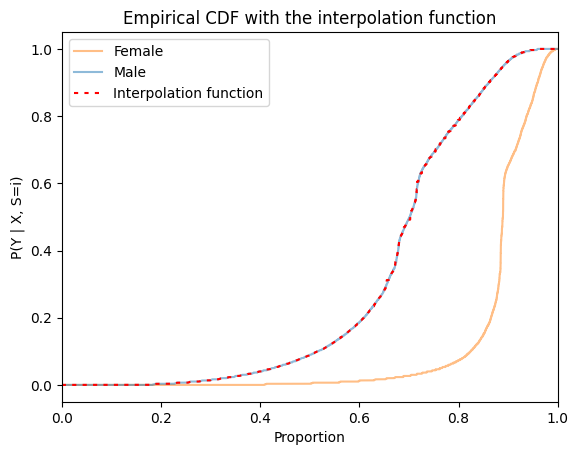

In [181]:
ax = sns.ecdfplot(
    data=df_proba,
    y="income_model_probability",
    hue="sex",
    alpha=0.5,
)

sns.ecdfplot(
    data=df_proba.loc[mask_female],
    y="interpolated_probability",
    ax=ax,
    alpha=1,
    color="red",
    dashes=(2, 3),
)
ax.set(
    ylabel="P(Y | X, S=i)",
    title="Empirical CDF with the interpolation function",
)
ax.legend(labels=["Female", "Male", "Interpolation function"]);  # fmt: skip

# Save DF for further analysis on the adult dataset


In [183]:
df_proba.to_csv("../Datasets/output/adult-probabilistic.csv", index=False)